In [75]:
!rm -r /content/tree


In [77]:
from google.colab import files
uploaded = files.upload()


Saving metrics.py to metrics.py
Saving usage.py to usage.py


Question 1

In [78]:
!mkdir tree
!touch tree/__init__.py

!mv base.py tree/
!mv utils.py tree/
!mv metrics.py tree/


In [79]:
!python usage.py


?(0 == -1.9187712152990415)
Y:
    Output: -0.0771017094141042
N:
    ?(1 == -1.236950710878082)
    Y:
        Output: 2.720169166589619
    N:
        ?(2 == -1.9596701238797756)
        Y:
            Output: 0.4738329209117875
        N:
            ?(3 == -1.913280244657798)
            Y:
                Output: -0.6800247215784908
            N:
                ?(4 == -2.6197451040897444)
                Y:
                    Output: 0.9633761292443218
                N:
                    Output: 0.19853387450545995
Criteria : information_gain
RMSE:  0.7821662514315317
MAE:  0.5761641056782679
?(0 == -1.9187712152990415)
Y:
    Output: -0.0771017094141042
N:
    ?(1 == -1.236950710878082)
    Y:
        Output: 2.720169166589619
    N:
        ?(2 == -1.9596701238797756)
        Y:
            Output: 0.4738329209117875
        N:
            ?(3 == -1.913280244657798)
            Y:
                Output: -0.6800247215784908
            N:
                ?(4 == -2.61974510

Question 2

In [80]:
import sys
sys.path.append("/content/tree/base.py")  # path that contains base.py
from base import DecisionTree
sys.path.append("/content/tree/metrics.py")  # path that contains base.py
from base import DecisionTree


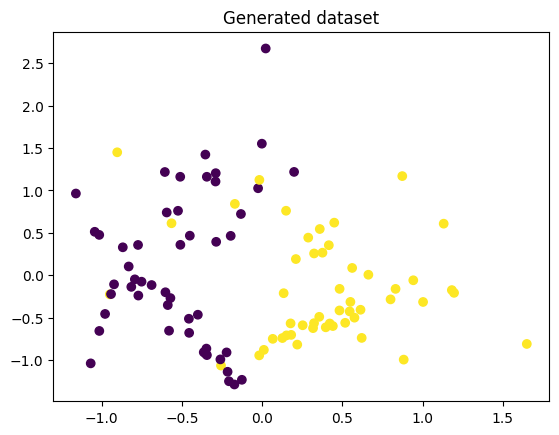

=== Q2 (a) Train/Test Split ===
Accuracy: 0.5
Class 0: Precision=0.0, Recall=0.0
Class 1: Precision=0.5, Recall=1.0
Fold 1: Best depth = 1, Accuracy = 0.5
Fold 2: Best depth = 1, Accuracy = 0.5
Fold 3: Best depth = 1, Accuracy = 0.45
Fold 4: Best depth = 1, Accuracy = 0.5
Fold 5: Best depth = 1, Accuracy = 0.45

=== Q2 (b) Nested CV Results ===
Per-fold accuracies: [np.float64(0.5), np.float64(0.5), np.float64(0.45), np.float64(0.5), np.float64(0.45)]
Average accuracy: 0.48
Optimum depth (most frequent): 1


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from base import DecisionTree
from metrics import *
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold

np.random.seed(42)

# Dataset generation

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2,
    random_state=1, n_clusters_per_class=2, class_sep=0.5
)

# Convert to pandas for our custom tree
X = pd.DataFrame(X, columns=["x1", "x2"])
y = pd.Series(y, dtype="category")

# Plot dataset
plt.scatter(X["x1"], X["x2"], c=y)
plt.title("Generated dataset")
plt.show()


# Q2 (a) Train/test split 70/30

def train_and_evaluate(X, y, max_depth=5):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    tree = DecisionTree(criterion="information_gain", max_depth=max_depth)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)

    print("=== Q2 (a) Train/Test Split ===")
    print("Accuracy:", accuracy(y_pred, y_test))
    for cls in y_test.unique():
        print(f"Class {cls}: Precision={precision(y_pred, y_test, cls)}, Recall={recall(y_pred, y_test, cls)}")


# Q2 (b) Nested cross-validation

def nested_cross_validation(X, y, depths=range(1, 11), outer_splits=5):
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
    best_depths = []
    outer_accuracies = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
        avg_scores = {}

        for d in depths:
            scores = []
            for inner_train_idx, inner_val_idx in inner_cv.split(X_train):
                X_inner_train, X_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
                y_inner_train, y_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

                tree = DecisionTree(criterion="information_gain", max_depth=d)
                tree.fit(X_inner_train, y_inner_train)
                preds = tree.predict(X_val)
                scores.append(accuracy(preds, y_val))

            avg_scores[d] = np.mean(scores)

        # pick best depth for this fold
        best_d = max(avg_scores, key=avg_scores.get)
        best_depths.append(best_d)

        # retrain with best_d
        best_tree = DecisionTree(criterion="information_gain", max_depth=best_d)
        best_tree.fit(X_train, y_train)
        final_preds = best_tree.predict(X_test)
        final_acc = accuracy(final_preds, y_test)
        outer_accuracies.append(final_acc)

        print(f"Fold {fold}: Best depth = {best_d}, Accuracy = {final_acc}")

    opt_depth = max(set(best_depths), key=best_depths.count)
    print("\n=== Q2 (b) Nested CV Results ===")
    print("Per-fold accuracies:", outer_accuracies)
    print("Average accuracy:", np.mean(outer_accuracies))
    print("Optimum depth (most frequent):", opt_depth)

# Run experiments

train_and_evaluate(X, y)
nested_cross_validation(X, y)


Question 3

/tmp/ipython-input-3511529636.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(


=== Q3 (a) Custom Decision Tree ===
MSE: 23.8101315895813
MAE: 3.918152678591915
R^2: 0.5499440848035528

=== Q3 (b) Sklearn Decision Tree ===
MSE: 10.081390320908294
MAE: 2.2961593623269154
R^2: 0.8094429117177016


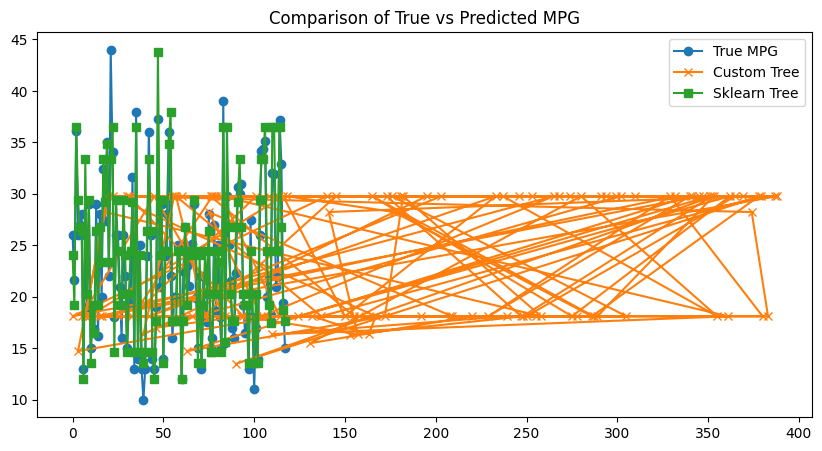

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from base import DecisionTree
from metrics import *
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)

# Load dataset

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
data = pd.read_csv(
    url,
    delim_whitespace=True,
    header=None,
    names=["mpg", "cylinders", "displacement", "horsepower", "weight",
           "acceleration", "model year", "origin", "car name"]
)


# Remove "car name" (string column not useful for regression)
data = data.drop(columns=["car name"])

# Replace '?' in horsepower with NaN, convert to numeric
data["horsepower"] = pd.to_numeric(data["horsepower"], errors="coerce")

# Drop rows with missing values
data = data.dropna().reset_index(drop=True)

# Features and target
X = data.drop(columns=["mpg"])
y = data["mpg"]

# Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Q3 (a) Custom Decision Tree

print("=== Q3 (a) Custom Decision Tree ===")

# Your DecisionTree (assuming it supports regression via variance gain)
tree = DecisionTree(criterion="variance_gain", max_depth=5)
tree.fit(X_train, y_train)

y_pred_custom = tree.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred_custom))
print("MAE:", mean_absolute_error(y_test, y_pred_custom))
print("R^2:", r2_score(y_test, y_pred_custom))


# Q3 (b) Sklearn Decision Tree

print("\n=== Q3 (b) Sklearn Decision Tree ===")

sk_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
sk_tree.fit(X_train, y_train)

y_pred_sklearn = sk_tree.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred_sklearn))
print("MAE:", mean_absolute_error(y_test, y_pred_sklearn))
print("R^2:", r2_score(y_test, y_pred_sklearn))


# Compare visually

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="True MPG", marker="o")
plt.plot(y_pred_custom, label="Custom Tree", marker="x")
plt.plot(y_pred_sklearn, label="Sklearn Tree", marker="s")
plt.legend()
plt.title("Comparison of True vs Predicted MPG")
plt.show()


Question 4

N=200, M=5, discrete->discrete | Train=0.11433s, Predict=0.02656s
N=200, M=5, real->discrete | Train=0.64098s, Predict=0.00134s
N=200, M=5, discrete->real | Train=0.11560s, Predict=0.02275s
N=200, M=5, real->real | Train=0.81465s, Predict=0.00130s
N=200, M=10, discrete->discrete | Train=0.46819s, Predict=0.02748s
N=200, M=10, real->discrete | Train=2.23605s, Predict=0.00239s
N=200, M=10, discrete->real | Train=1.00779s, Predict=0.03231s
N=200, M=10, real->real | Train=2.79539s, Predict=0.00188s
N=500, M=5, discrete->discrete | Train=0.10482s, Predict=0.05448s
N=500, M=5, real->discrete | Train=1.56688s, Predict=0.00230s
N=500, M=5, discrete->real | Train=0.11867s, Predict=0.05830s
N=500, M=5, real->real | Train=2.00352s, Predict=0.00254s
N=500, M=10, discrete->discrete | Train=1.15006s, Predict=0.07202s
N=500, M=10, real->discrete | Train=5.56424s, Predict=0.00417s
N=500, M=10, discrete->real | Train=1.97298s, Predict=0.07392s
N=500, M=10, real->real | Train=7.10283s, Predict=0.00438s


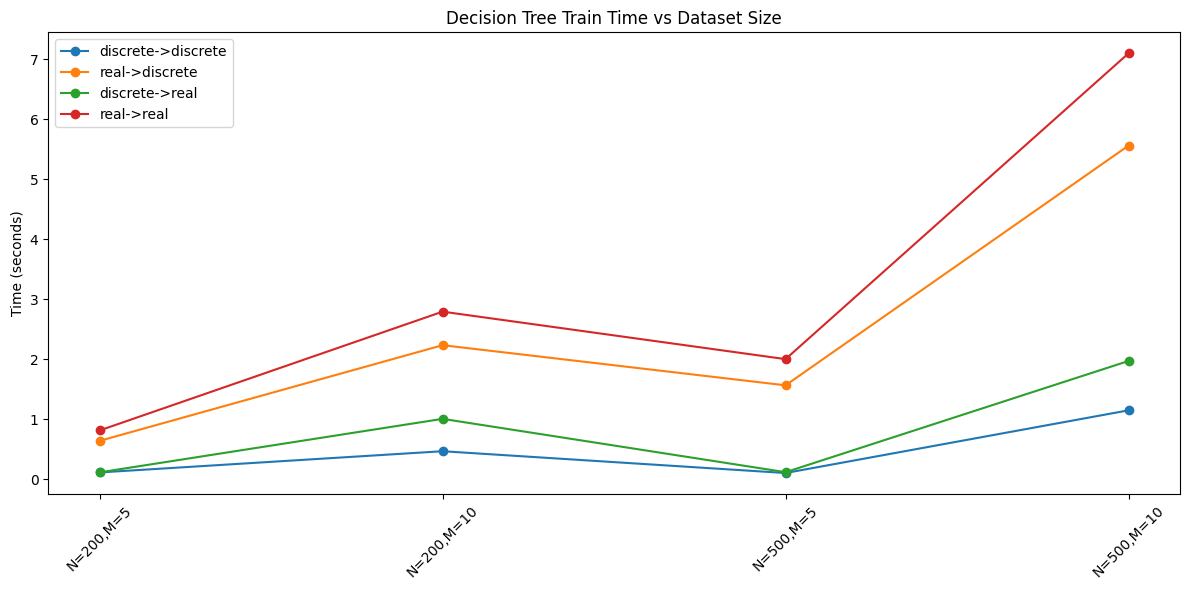


=== Prediction Time Plot ===


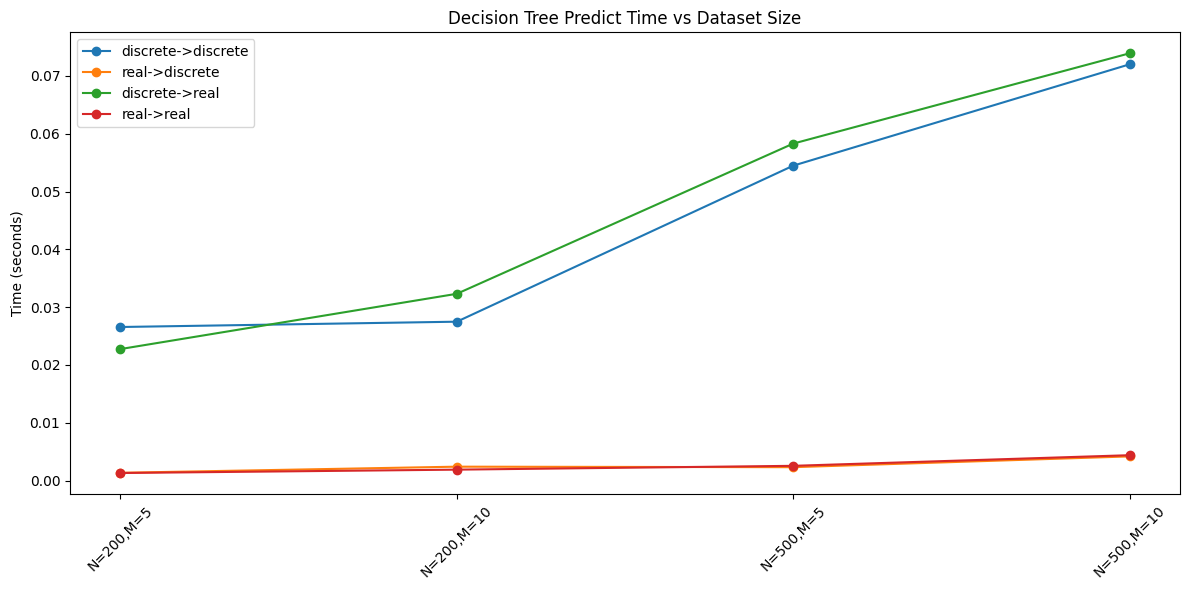


Theoretical Complexity:
Training ≈ O(N × M × log N)
Prediction ≈ O(depth × N_test), depth ≈ O(log N)


In [84]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from base import DecisionTree

np.random.seed(42)
num_average_time = 10  # number of runs for averaging

# Generate fake dataset

def generate_data(N, M, input_type="real", output_type="real"):
    if input_type == "real":
        X = pd.DataFrame(np.random.randn(N, M))
    else:  # discrete input
        X = pd.DataFrame(np.random.randint(0, 2, size=(N, M))).astype("category")

    if output_type == "real":
        y = pd.Series(np.random.randn(N))
    else:  # discrete output
        y = pd.Series(np.random.randint(0, 2, size=N), dtype="category")

    return X, y

# Measure training and prediction times

def measure_time(N_values, M_values, tree_cases):
    results = {case: {"train": [], "predict": []} for case in tree_cases}

    for N in N_values:
        for M in M_values:
            for case in tree_cases:
                input_type, output_type = case.split("->")
                X, y = generate_data(N, M, input_type, output_type)

                # Train-test split: 70%-30%
                X_train, y_train = X.iloc[:int(0.7*N)], y.iloc[:int(0.7*N)]
                X_test, y_test = X.iloc[int(0.7*N):], y.iloc[int(0.7*N):]

                train_times, predict_times = [], []

                for _ in range(num_average_time):
                    clf = DecisionTree(criterion="information_gain", max_depth=10)
                    start = time.time()
                    clf.fit(X_train, y_train)
                    train_times.append(time.time() - start)

                    start = time.time()
                    clf.predict(X_test)
                    predict_times.append(time.time() - start)

                avg_train = np.mean(train_times)
                avg_predict = np.mean(predict_times)

                results[case]["train"].append(avg_train)
                results[case]["predict"].append(avg_predict)

                print(f"N={N}, M={M}, {case} | Train={avg_train:.5f}s, Predict={avg_predict:.5f}s")

    return results

# Plot results

def plot_results(N_values, M_values, results, mode="train"):
    plt.figure(figsize=(12,6))
    for case in results:
        plt.plot(range(len(results[case][mode])), results[case][mode], marker="o", label=case)

    xticks = [f"N={N},M={M}" for N in N_values for M in M_values]
    plt.xticks(range(len(xticks)), xticks, rotation=45)
    plt.ylabel("Time (seconds)")
    plt.title(f"Decision Tree {mode.capitalize()} Time vs Dataset Size")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main experiment

if __name__ == "__main__":
    N_values = [200, 500]  # vary samples
    M_values = [5, 10]       # vary features

    tree_cases = [
        "discrete->discrete",
        "real->discrete",
        "discrete->real",
        "real->real"
    ]

    results = measure_time(N_values, M_values, tree_cases)

    print("\n=== Training Time Plot ===")
    plot_results(N_values, M_values, results, mode="train")

    print("\n=== Prediction Time Plot ===")
    plot_results(N_values, M_values, results, mode="predict")

    print("\nTheoretical Complexity:")
    print("Training ≈ O(N × M × log N)")
    print("Prediction ≈ O(depth × N_test), depth ≈ O(log N)")
